In [1]:
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse as sp

%matplotlib inline
import seaborn as sns
import math
import itertools
from sklearn import mixture
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.manifold import Isomap
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans as KMeanspkg
from sklearn.decomposition import FastICA 
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import MDS
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import time
import umap
import hdbscan
from scipy import linalg
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score

def printmd(string):
    display(Markdown(string))

In [2]:
dim_13 = pd.read_csv('/users/PAS1376/karkhanis6/Cytometry/Levine_13dim.txt', sep = "\t", header=0)
dim_13.head()

,CD45,CD45RA,CD19,CD11b,CD4,CD8,CD34,CD20,CD33,CD123,CD38,CD90,CD3,label
0,3.138041,1.618552,0.525611,-0.104680,0.811363,1.740672,0.531365,-0.153811,4.291140,2.615224,4.646570,1.849447,1.280036,1.0
1,3.486871,2.247755,0.309583,0.833397,1.550594,1.829030,-0.033018,0.290684,4.672004,1.532877,4.253449,0.422374,0.066806,1.0
2,2.145520,0.796811,-0.116073,0.186249,0.529898,0.834876,0.734445,1.590881,4.473149,0.443484,4.511387,0.124615,-2.066902,1.0
3,4.321869,0.167016,-0.639139,-0.020982,1.814245,-0.094315,1.416341,-0.028213,4.295604,2.546383,5.004100,1.326005,-1.015953,1.0
4,2.633997,0.714859,-0.173889,-0.042410,0.450911,1.587902,0.731608,0.139234,4.115300,1.579856,5.065479,0.632904,-0.703904,1.0


### Filtering labeled and unlabeled data

In [3]:
dim_13_labeled = dim_13[dim_13.label.notnull()]     # Labeled data
dim_13_labeled_data = dim_13_labeled[dim_13_labeled.columns[dim_13_labeled.columns != 'label']] # labeled data without labels
dim_13_labels = dim_13_labeled['label']    # labels of labeled data

In [4]:
dim_13_unlabeled_data = dim_13[dim_13.label.isnull()]   # unlabeled data
del dim_13_unlabeled_data['label']                      # deleting 'label' column of unlabeled data

In [5]:
classes = ['CD11b-_Monocyte_cells', 'CD11bhi_Monocyte_cells', 'CD11bmid_Monocyte_cells', 'CMP_cells', 'Erythroblast_cells',
           'GMP_cells', 'HSC_cells', 'Immature_B_cells', 'Mature_CD38lo_B_cells', 'Mature_CD38mid_B_cells', 
           'Mature_CD4+_T_cells', 'Mature_CD8+_T_cells', 'Megakaryocyte_cells', 'MEP_cells', 'MPP_cells', 'Myelocyte_cells', 
           'Naive_CD4+_T_cells', 'Naive_CD8+_T_cells', 'NK_cells', 'Plasma_cell_cells', 'Plasmacytoid_DC_cells', 
           'Platelet_cells', 'Pre-B_I_cells', 'Pre-B_II_cells']

# Validation Data

In [ ]:
validation_data = pd.read_csv('/users/PAS1376/karkhanis6/Cytometry/Semi_Clustering/13dim/40-60_Balanced_Model_&_Data/0.6_validation_data.txt')

In [ ]:
validation_samples = validation_data.drop(['label'], axis = 1) 
validation_labels = validation_data['label']    

## Functions for different Dimensionality Reduction Techniques, Ploting of reduced dimensional data, adding cluster (label) column in the newly created dataframe

In [25]:
def pca(data, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(data)
    data_pca = pca.transform(data)
    return data_pca
        
def ica(data, n_components):
    ica = FastICA(n_components = n_components)
    data_ica = ica.fit_transform(data)
    return data_ica
        
def fa(data, n_components):
    fa = FactorAnalysis(n_components = n_components, max_iter=5000)
    data_fa = fa.fit_transform(data)
    return fa, data_fa
        
def svd(data, n_components):
    svd = TruncatedSVD(n_components = n_components)
    data_svd = svd.fit_transform(data)
    return data_svd
        
def mds(data, n_components):
    mds = MDS(n_components = n_components)
    data_mds = mds.fit_transform(data)
    return data_mds

def tsne(data, n_components):
    tsne = TSNE(n_components = n_components)
    data_tsne = tsne.fit_transform(data)
    return data_tsne

def u_map(data, n_components):
    u_map = umap.UMAP(n_components = n_components, n_neighbors=200)
    data_umap = u_map.fit_transform(data)
    return data_umap

def isomap(data, n_components):
    isomap = Isomap(n_components = n_components)
    data_isomap = isomap.fit_transform(data)
    return data_isomap
        
def Dim_Red_Plot (data, labels):
    '''
    data = reduced dim data
    labels =  labels of data  
    '''
    plt.figure(figsize=(10,6))
    plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], s=8, cmap='nipy_spectral', c=labels, alpha=0.5)
    cbar = plt.colorbar(boundaries=np.arange(25)-0.5)
    cbar.set_ticks(np.arange(24))
    cbar.set_ticklabels(classes)

    plt.xlabel('component 1')
    plt.ylabel('component 2')

def addcluster(data, labels):
    data = pd.DataFrame(data)
    data.columns = ['1d','2d']
    labeled_data = data.copy()
    labeled_data['cluster'] = labels.astype('int64')
    return labeled_data

## Creating Clusters using K-Means
###  Finding Optimal Number of Clusters

There are two primary methods to define number of clusters:

- Elbow criterion (visual method)
  - Plot number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster center.

- Silhouette Score (math method)
  - Measures intra- and inter-cluster distance
  
Here I am using silhouette score to choose an optimal value for n_clusters.

###  Silhouette Score

- The Silhouette Score is from -1 to 1 and show how close or far away the clusters are from each other and how dense the clusters are. The closer your silhouette score is to 1 the more distinct your clusters are.
- If your score is 1 think of your clusters as perfect little balls that are far away from each other with no miss classification. Values near 0 indicate overlapping clusters.
- The Silhouette Coefficient is calculated using the mean intra-cluster distance $a$ and the mean nearest-cluster distance $b$ for each sample. 
- The Silhouette Coefficient for a sample is $\frac{b - a} {max(a, b)}$. To clarify, $b$ is the distance between a sample and the nearest cluster that the sample is not a part of. 
  - Note that Silhouette Coefficient is only defined if number of labels is $2 \leq n_{labels} \leq (n_{samples} - 1)$.  
- We used function **silhouette_score** to compute the mean Silhouette Coefficient of all samples.

###  Silhouette Plot

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters.

In [ ]:
def silhouette_plot(data, range_n_clusters, lim_x, mat_size):
    #plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

    for n_clusters in range_n_clusters:
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(10, 4)
        ax1.set_xlim([lim_x[0], lim_x[1]])
        
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
        y_lower = 10
        
        kmeans = KMeanspkg(init='k-means++', n_clusters = n_clusters, n_init=30)
        clusters = kmeans.fit_predict(data)
        sample_silhouette_values = silhouette_samples(data, clusters)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(data, clusters)    
        
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            #color = cm.spectral(float(i) / n_clusters) facecolor=color, edgecolor=color,       
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)
        
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
       
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10
            plt.suptitle(("Silhouette analysis for KMeans clustering with n_clusters = %d" % n_clusters), 
                          fontsize=14, fontweight='bold')
        print("For n_clusters =", n_clusters, '\n', "The average silhouette_score is :", silhouette_avg)
        plt.show()    

## Functions for KMeans, calculation of SSB and SSE
### SSB - Sum of Squares Between Different Clusters  
### SSE - Total Sum of Squares Within Each Cluster

In [15]:
# Functions of KMeans

def initializeCentroids(k, d, low = 0, high = 1):
    return np.random.uniform(low, high, size = (k,d))

def setClusters(data, centroids, euclidean):
    return np.apply_along_axis(euclidean, 1, data, centroids)


def euclideanRank(centroids, point, nsmall = 0):
    return rankCluster(np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = 1)), nsmall)

def euclideanDist(centroids, point):
    return np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = len(centroids.shape)-1)) # Hack

def rankCluster(y, n):
    return np.argpartition(y, n)[n]+1

def updateCentroids(data, clusters, centroids):
    for i in range(centroids.shape[0]):
        if i+1 in clusters:
            centroids[i, ] = data[np.where(clusters == i+1), ].mean(axis = 1)
    return centroids

def nSmallestDistPoints(points, n):
    l = []
    for i in range(points.shape[0]):
        l = np.append(l, euclideanDist(points, points[i, ]))

    n *= 2
    ind = np.argpartition(l, points.shape[0] + n)[points.shape[0] + n]
    r = int(np.floor(ind / points.shape[0]))
    c = int(np.floor(ind % points.shape[0]))
    return r, c, l[ind]

def reallyreallyInitializeCentroids(data, k):
    centroids = data[np.random.randint(0, data.shape[0], k), ]
    replacement_counter = 0
    for i in range(data.shape[0]):
        case = data[i, ]
        closest1, closest2, dist = nSmallestDistPoints(centroids, 1)
        if np.min(euclideanDist(centroids, case)) > dist:
            if euclideanDist(centroids[closest1, ], case) > euclideanDist(centroids[closest2, ], case):
                centroids[closest2, ] = case
            else:
                centroids[closest1, ] = case
            replacement_counter += 1
        else:
            second_closest_case = np.argpartition(euclideanDist(centroids, case), 1)[1]
            first_closest_case = np.argpartition(euclideanDist(centroids, case), 0)[0]
            closest_to_second_closest_case = np.argpartition(euclideanDist(centroids, centroids[second_closest_case, ]), 1)[1]
            #closest1, closest2, dist = nSmallestDistPoints(centroids, 2)

            if np.partition(euclideanDist(centroids, case), 1)[1] > euclideanDist(centroids[second_closest_case, ], centroids[closest_to_second_closest_case, ]):
                centroids[first_closest_case, ] = case
                replacement_counter += 1
    #print('Centroids replaced %d time(s).' % (replacement_counter))
    return centroids

def KMeansFormal(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    
    return pd.DataFrame({'RowID' : [i for i in range(len(clusters))], 'Cluster' : clusters})

def KMeans(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    return centroids, run_counter, clusters

def calculateMeasures(data, clusters, centroids):
    Total_SSW, SSB = 0, 0
    SSW_clusterwise = []
    for i in range(centroids.shape[0]):
        SSB += euclideanDist(np.mean(data, axis = 0), centroids[i]) * len(np.where(clusters == i+1)[0])
        cluster_filter = np.where(clusters == i+1)
        if len(cluster_filter[0]) == 0:
            temp = 0
        else:
            temp = np.sum(np.apply_along_axis(euclideanDist, 1, data[cluster_filter], centroids[i]))
        Total_SSW += temp
        SSW_clusterwise.append(temp)
        
    return Total_SSW, SSB, SSW_clusterwise

## Functions for kmeans, Spectral Clustering (off-the-shelves) and plotting of clusters

In [16]:
def kmeans_pkg(data, n_clusters):
    kmeans = KMeanspkg(n_clusters = n_clusters).fit(data)
    y_kmeans = kmeans.predict(data)
    centers = kmeans.cluster_centers_
    return y_kmeans, centers

def kmeans_plt (data, y_kmeans, centers):    
    plt.figure(figsize=(10,6))
    plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=8, cmap='nipy_spectral')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=40, alpha=0.5)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()
    
def spectralclustering(data, n_clusters):
    spectral = SpectralClustering(n_clusters = n_clusters).fit(data)
    y_spectral = spectral.predict(data)
    # centers = spectral.cluster_centers_
    return y_spectral

def spectral_plt (data, y_spectral):    
    plt.figure(figsize=(13,9))
    plt.scatter(data[:, 0], data[:, 1], c=y_spectral, s=50, cmap='nipy_spectral')
    # plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)
    plt.show()
    
def Mixture_model(data, n_components):
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full').fit(data)
    y_gmm = gmm.predict(data)
    return y_gmm

## Function for printing SSB and SSE of True clusters

In [17]:
def True_measures(data, labeled_data):
    printmd('### True Cluster Membership')
    Total_SSW, SSB, SSW_clusterwise = calculateMeasures(data, labeled_data.cluster.values,
                                          updateCentroids(data, labeled_data.cluster.values, 
                                                          np.zeros((24,data.shape[1]))))
    print('SSB : %f' % (SSB))
    print('Total_SSW : %f' % (Total_SSW))
    print('Cluster-wise SSW:')
    for i,x in enumerate(SSW_clusterwise):
        print('Cluster %d: %f' %(i+1, round(x,2)))

## Functions for printing SSB and SSE of newly created clusters 

In [18]:
def new_measures(data, n_clusters):
    centroids, iterations, clusters = KMeans(n_clusters, data)

    printmd('### Class membership when K = 24')
    Total_SSW, SSB, SSW_clusterwise = calculateMeasures(data, clusters, centroids)
    print('SSB : %f' % (SSB))
    print('Total_SSW : %f' % (Total_SSW))
    print('Cluster-wise SSW:')
    for i,x in enumerate(SSW_clusterwise):
        print('Cluster %d: %f' %(i+1, round(x,2)))

    print('\nIteration till convergence : %d' %(iterations))

## Function for Accuracy calculation with cluster_numbers (k) from 1 to 24

In [19]:
def accuracycalculation (data):
    accuracy =[]
    for i in range(1,25):
        kmeans = KMeanspkg(n_clusters = i).fit(data)
        y_kmeans = kmeans.predict(data)
        
        table = pd.crosstab(pd.Series(dim_13_labels, name = 'True Labels'), pd.Series(y_kmeans, name = 'Assigned Label'))
        
        Labelwise_accuracy = table.apply(lambda r: r.max()/r.sum(), axis =1).sum(axis = 0)*100/len(table)
        
        accuracy.append({'Accuracy': round(Labelwise_accuracy,2), '# Clusters': i})
    return pd.DataFrame(accuracy)

In [20]:
def accuracycalculation_gmm (data):
    accuracy =[]
    for i in range(1,25):
        gmm = mixture.GaussianMixture(n_components=i, covariance_type='full').fit(data)
        y_gmm = gmm.predict(data)
        
        table = pd.crosstab(pd.Series(dim_13_labels, name = 'True Labels'), pd.Series(y_gmm, name = 'Assigned Label'))
        
        Labelwise_accuracy = table.apply(lambda r: r.max()/r.sum(), axis =1).sum(axis = 0)*100/len(table)
        
        accuracy.append({'Accuracy': round(Labelwise_accuracy,2), '# Components': i})
    return pd.DataFrame(accuracy)

## Function for F1_measure

In [21]:
def contingency_matrix(labels_true, labels_pred, eps=None, sparse=False):
    """Build a contingency matrix describing the relationship between labels.
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        Ground truth class labels to be used as a reference
    labels_pred : array, shape = [n_samples]
        Cluster labels to evaluate
    eps : None or float, optional.
        If a float, that value is added to all values in the contingency
        matrix. This helps to stop NaN propagation.
        If ``None``, nothing is adjusted.
    sparse : boolean, optional.
        If True, return a sparse CSR continency matrix. If ``eps is not None``,
        and ``sparse is True``, will throw ValueError.

    Returns
    -------
    contingency : {array-like, sparse}, shape=[n_classes_true, n_classes_pred]
        Matrix :math:`C` such that :math:`C_{i, j}` is the number of samples in
        true class :math:`i` and in predicted class :math:`j`. If
        ``eps is None``, the dtype of this array will be integer. If ``eps`` is
        given, the dtype will be float.
        Will be a ``scipy.sparse.csr_matrix`` if ``sparse=True``.
    """

    if eps is not None and sparse:
        raise ValueError("Cannot set 'eps' when sparse=True")

    classes, class_idx = np.unique(labels_true, return_inverse=True)
    clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
    n_classes = classes.shape[0]
    n_clusters = clusters.shape[0]
    # Using coo_matrix to accelerate simple histogram calculation,
    # i.e. bins are consecutive integers
    # Currently, coo_matrix is faster than histogram2d for simple cases
    contingency = sp.coo_matrix((np.ones(class_idx.shape[0]),
                                 (class_idx, cluster_idx)),
                                shape=(n_classes, n_clusters),
                                dtype=np.int)
    if sparse:
        contingency = contingency.tocsr()
        contingency.sum_duplicates()
    else:
        contingency = contingency.toarray()
        if eps is not None:
            # don't use += as contingency is integer
            contingency = contingency + eps
    return contingency

In [22]:
def F1_measure(labels_true, labels_pred, sparse=False):
    n_samples, = labels_true.shape

    c = contingency_matrix(labels_true, labels_pred,
                           sparse=True)
    
    tk = np.dot(c.data, c.data) - n_samples
    pk = np.sum(np.asarray(c.sum(axis=0)).ravel() ** 2) - n_samples
    qk = np.sum(np.asarray(c.sum(axis=1)).ravel() ** 2) - n_samples
    return (2*tk/(qk+pk))
    # return np.sqrt(tk / pk) * np.sqrt(tk / qk) if tk != 0. else 0

# No Dim Reduction Clustering

In [29]:
y_kmeans, _ = kmeans_pkg(data_pca, 24)
print("F1-Score for Kmeans =", F1_measure(dim_13_labels, y_kmeans))
print("Adjusted Rand index for Kmeans =", adjusted_rand_score(dim_13_labels, y_kmeans))
print("FMI for Kmeans =", fowlkes_mallows_score(dim_13_labels, y_kmeans)) 
print("V-measure Score for Kmeans =", v_measure_score(dim_13_labels, y_kmeans))

F1-Score for Kmeans = 0.28611472413781147
Adjusted Rand index for Kmeans = 0.23522719003093698
FMI for Kmeans = 0.3061339073793642
V-measure Score for Kmeans = 0.4939605650048727


In [30]:
y_gmm = Mixture_model(dim_13_labeled_data, 24)
print("F1-Score for Kmeans =", F1_measure(dim_13_labels, y_gmm))
print("Adjusted Rand index for Kmeans =", adjusted_rand_score(dim_13_labels, y_gmm))
print("FMI for Kmeans =", fowlkes_mallows_score(dim_13_labels, y_gmm)) 
print("V-measure Score for Kmeans =", v_measure_score(dim_13_labels, y_gmm))

F1-Score for Kmeans = 0.5299080009757792
Adjusted Rand index for Kmeans = 0.49352176741670606
FMI for Kmeans = 0.5562969278844531
V-measure Score for Kmeans = 0.7040830041117887


In [31]:
y_HDBSCAN = hdbscan.HDBSCAN(min_samples=10,min_cluster_size=500).fit_predict(dim_13_labeled_data)
print("F1-Score for Kmeans =", F1_measure(dim_13_labels, y_HDBSCAN))
print("Adjusted Rand index for Kmeans =", adjusted_rand_score(dim_13_labels, y_HDBSCAN))
print("FMI for Kmeans =", fowlkes_mallows_score(dim_13_labels, y_HDBSCAN)) 
print("V-measure Score for Kmeans =", v_measure_score(dim_13_labels, y_HDBSCAN))

F1-Score for Kmeans = 0.5958455935523407
Adjusted Rand index for Kmeans = 0.5342483683379247
FMI for Kmeans = 0.6207933280426722
V-measure Score for Kmeans = 0.6571609008327979


# Principal Component Analysis (PCA)

In [18]:
def pcaplot(data, n_comp):
    printmd('### Analysis of PCA')
    # n_comp = [13, 11, 9, 7, 5, 3, 2]
    
    for i in range(len(n_comp)):
        pca = PCA(n_components = n_comp[i])
        pca.fit(data)
        data_pca = pca.transform(data)
        pca_restored = pca.inverse_transform(data_pca)
        print('------------------------')
        print('pc shape: %d x %d' %data_pca.shape)
        print('%d principal components' % (n_comp[i]))
        print('Variance retained %.2f%%' % (sum(pca.explained_variance_ratio_) * 100))

        plt.figure(2, figsize=(5,2), dpi=100)
        xlab = ['PC %s' % j for j in list(range(0, n_comp[i]))]
        x = list(range(0, n_comp[i]))
        y = pca.explained_variance_ratio_
        ycum = y.cumsum()
        # grid(b=None, which='major', axis='both')
        plt.bar(x, y)
        plt.plot(x, ycum, c='red', marker='o', linewidth = 1)
        plt.axis(ymin=0, ymax=1)
        plt.xlabel('Principal Components')
        plt.ylabel('Explained Variance')
        plt.show()

### Analysis of PCA

------------------------
pc shape: 81747 x 13
13 principal components
Variance retained 100.00%


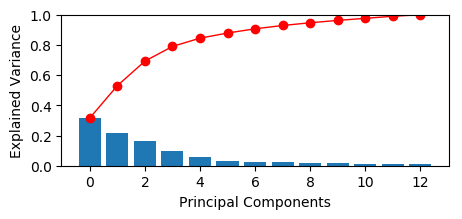

------------------------
pc shape: 81747 x 11
11 principal components
Variance retained 97.61%


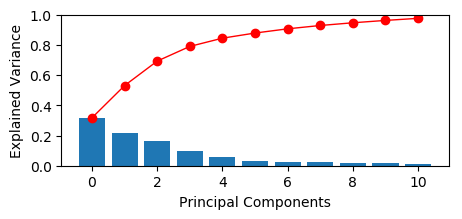

------------------------
pc shape: 81747 x 9
9 principal components
Variance retained 94.67%


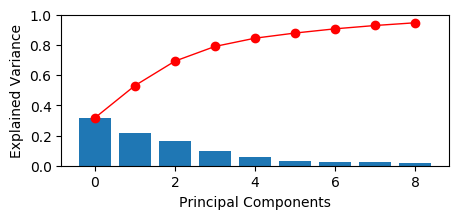

------------------------
pc shape: 81747 x 7
7 principal components
Variance retained 90.67%


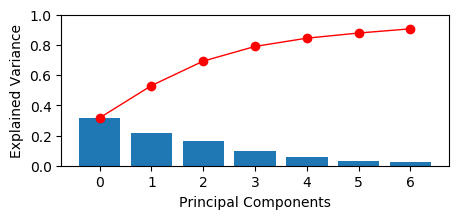

------------------------
pc shape: 81747 x 5
5 principal components
Variance retained 84.47%


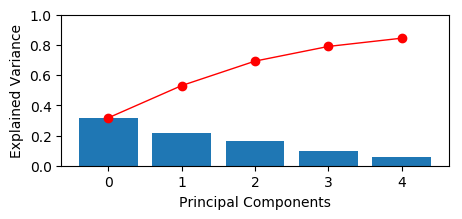

------------------------
pc shape: 81747 x 3
3 principal components
Variance retained 69.28%


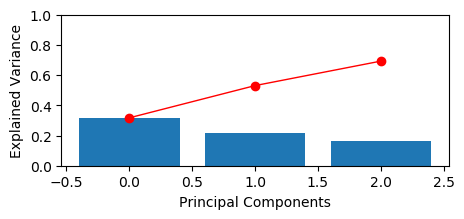

------------------------
pc shape: 81747 x 2
2 principal components
Variance retained 53.06%


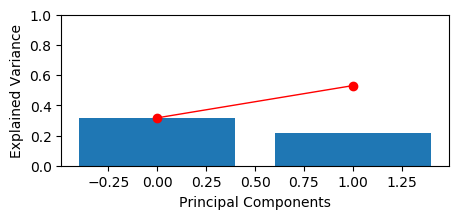

In [19]:
pcaplot(dim_13_labeled_data, n_comp = [13, 11, 9, 7, 5, 3, 2])

--- 0.11245846748352051 seconds ---


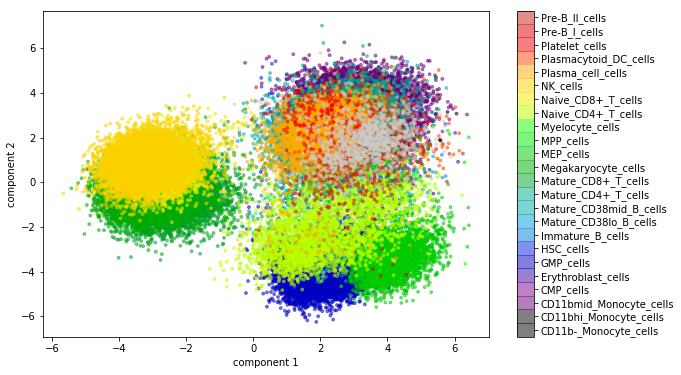

In [20]:
start_time_pca = time.time()
data_pca = pca(dim_13_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_pca))
Dim_Red_Plot (data_pca, dim_13_labels)

In [21]:
labeled_data_pca = addcluster(data_pca, dim_13_labels)

For n_clusters = 2 
 The average silhouette_score is : 0.5653854179765737


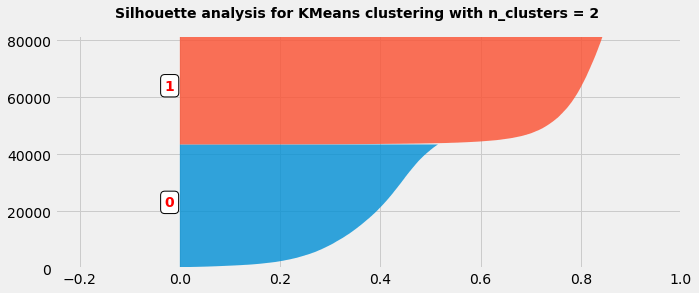

For n_clusters = 3 
 The average silhouette_score is : 0.7178628890688391


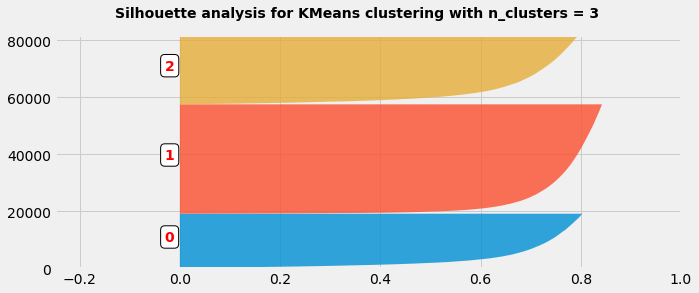

For n_clusters = 4 
 The average silhouette_score is : 0.6059943731034336


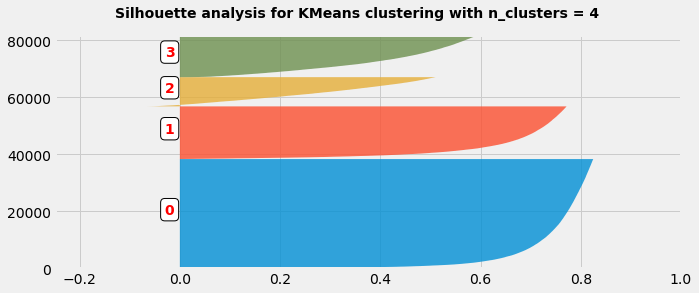

For n_clusters = 5 
 The average silhouette_score is : 0.43806526486674763


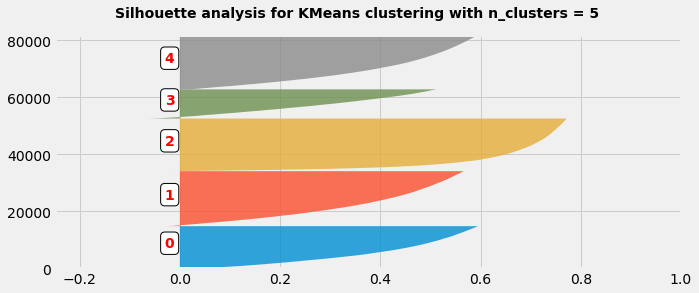

In [13]:
matrix_pca = pd.DataFrame(data_pca).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.25, 1]
silhouette_plot(matrix_pca, [2, 3, 4, 5], [-0.25, 1], len(data_pca))

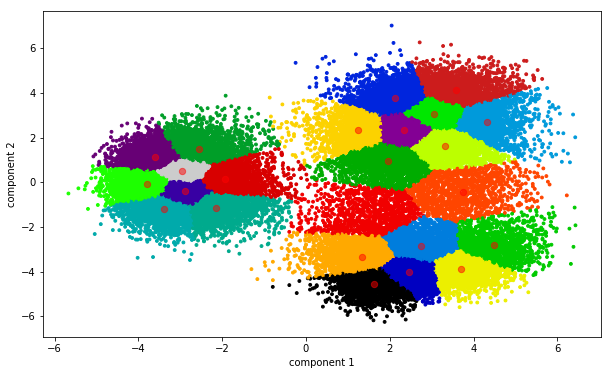

In [20]:
y_kmeans_pca , centers_pca = kmeans_pkg(data_pca, 24)
kmeans_plt (data_pca, y_kmeans_pca, centers_pca)

In [21]:
True_measures(data_pca, labeled_data_pca)

### True Cluster Membership

SSB : 291365.232471
Total_SSW : 76708.730395
Cluster-wise SSW:
Cluster 1: 947.500000
Cluster 2: 6780.260000
Cluster 3: 1310.490000
Cluster 4: 332.780000
Cluster 5: 10343.660000
Cluster 6: 108.580000
Cluster 7: 414.440000
Cluster 8: 1092.910000
Cluster 9: 8550.100000
Cluster 10: 784.730000
Cluster 11: 11679.830000
Cluster 12: 6776.450000
Cluster 13: 3170.830000
Cluster 14: 239.080000
Cluster 15: 272.560000
Cluster 16: 4697.620000
Cluster 17: 5094.790000
Cluster 18: 7551.690000
Cluster 19: 4169.940000
Cluster 20: 623.150000
Cluster 21: 344.400000
Cluster 22: 2.550000
Cluster 23: 289.710000
Cluster 24: 1130.660000


In [23]:
new_measures(data_pca, 24)

### Class membership when K = 24

SSB : 297368.277761
Total_SSW : 42160.918751
Cluster-wise SSW:
Cluster 1: 1701.430000
Cluster 2: 1142.230000
Cluster 3: 1186.660000
Cluster 4: 1194.540000
Cluster 5: 1169.670000
Cluster 6: 1580.430000
Cluster 7: 0.000000
Cluster 8: 1825.820000
Cluster 9: 3508.170000
Cluster 10: 1416.200000
Cluster 11: 1468.360000
Cluster 12: 1307.740000
Cluster 13: 1779.080000
Cluster 14: 1353.040000
Cluster 15: 2498.460000
Cluster 16: 934.020000
Cluster 17: 1535.250000
Cluster 18: 1129.390000
Cluster 19: 1096.380000
Cluster 20: 3437.690000
Cluster 21: 3565.160000
Cluster 22: 2919.280000
Cluster 23: 1526.240000
Cluster 24: 2885.670000

Iteration till convergence : 169


In [48]:
#table_pca = pd.crosstab(pd.Series(dim_13_labels, name = 'True Labels'), pd.Series(y_kmeans_pca, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (PCA)')
#table_pca

In [47]:
#No_of_Misclassified_Cells_pca = table_pca.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (PCA)')
#No_of_Misclassified_Cells_pca

In [46]:
#printmd('### Coverage Matrix for k=3 (PCA)')
#coverage_matrix_pca = table_pca.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_pca

In [45]:
#print('total coverage for PCA : %f' % (coverage_matrix_pca.values.sum()/(len(table_pca)*3)))

In [24]:
accuracy_pca = accuracycalculation (data_pca)
printmd('### Accuracy Matrix (PCA-Kmeans)')
accuracy_pca

### Accuracy Matrix (PCA-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,99.81
2,3,91.52
3,4,79.16
4,5,76.36
5,6,73.25
6,7,70.41
7,8,67.78
8,9,62.04
9,10,61.48


In [25]:
print("F1-Score for PCA-Kmeans =", F1_measure(dim_13_labels, y_kmeans_pca))

F1-Score for PCA-Kmeans = 0.285702979956


In [26]:
print("Adjusted Rand index for PCA-Kmeans =", adjusted_rand_score(dim_13_labels, y_kmeans_pca))

Adjusted Rand index for PCA-Kmeans = 0.234809773809


In [27]:
print("FMI for PCA-Kmeans =", fowlkes_mallows_score(dim_13_labels, y_kmeans_pca)) 

FMI for PCA-Kmeans = 0.30572819007


In [28]:
print("V-measure Score for PCA-Kmeans =", v_measure_score(dim_13_labels, y_kmeans_pca))

V-measure Score for PCA-Kmeans = 0.493518078233


# Factor Analysis (FA)

In [22]:
data_fa = np.array(pd.read_csv('Reduced_dim_data/dim_13_data_fa.txt', sep = ",", header=-1))

--- 99.20073199272156 seconds ---


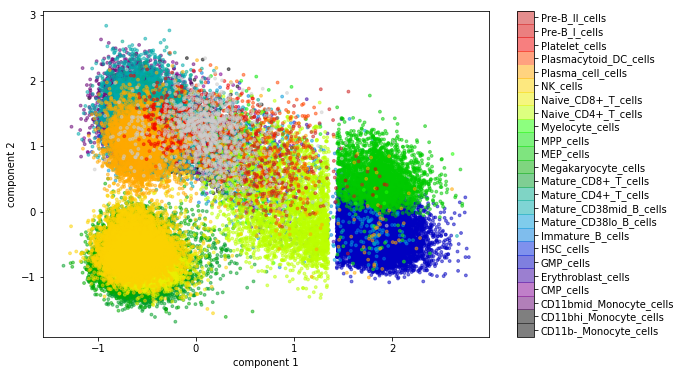

In [19]:
start_time_fa = time.time()
# fa, data_fa = fa(dim_13_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_fa))
Dim_Red_Plot (data_fa, dim_13_labels)

In [20]:
# np.savetxt("data_fa.txt", data_fa, delimiter=",")

## Analysis of FA

In [ ]:
c2 = np.sum(fa.components_ ** 2, axis=1)
total_variance_ = np.sum(c2)
pvars_ = 100 * c2 / total_variance_
pvars_noise_ = 100 * c2 / (total_variance_ + np.sum(fa.noise_variance_))
print(' variance explained without noise =')
print(pvars_)
print('-'*40)
print(' variance explained with noise =')
print(pvars_noise_)

In [24]:
labeled_data_fa = addcluster(data_fa, dim_13_labels)

For n_clusters = 2 
 The average silhouette_score is : 0.5495911344279101


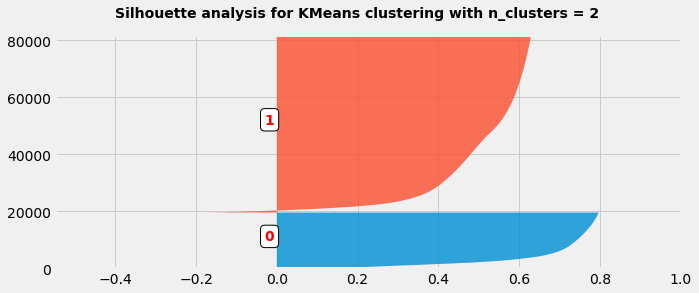

For n_clusters = 3 
 The average silhouette_score is : 0.7332930514246775


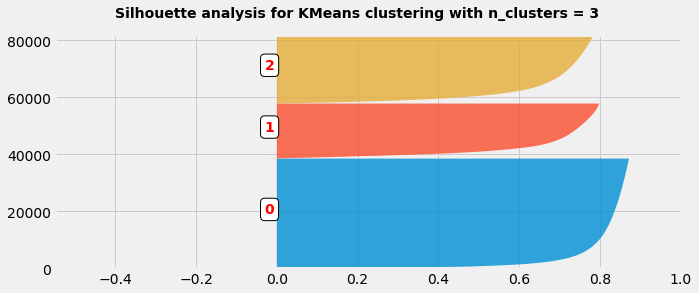

For n_clusters = 4 
 The average silhouette_score is : 0.6724319147367787


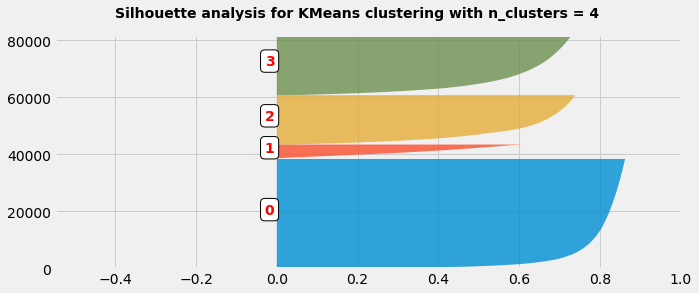

For n_clusters = 5 
 The average silhouette_score is : 0.6268884357739635


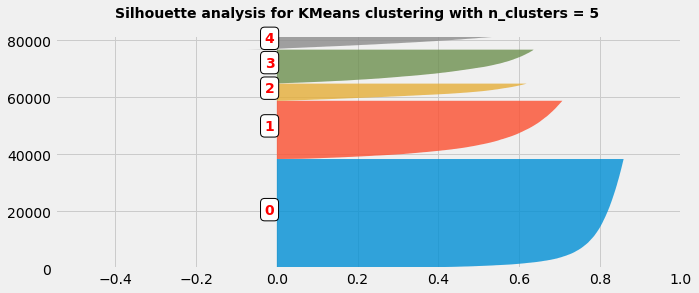

In [40]:
matrix_fa = pd.DataFrame(data_fa).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.55, 1]
silhouette_plot(matrix_fa, [2, 3, 4, 5], [-0.55, 1], len(data_fa))

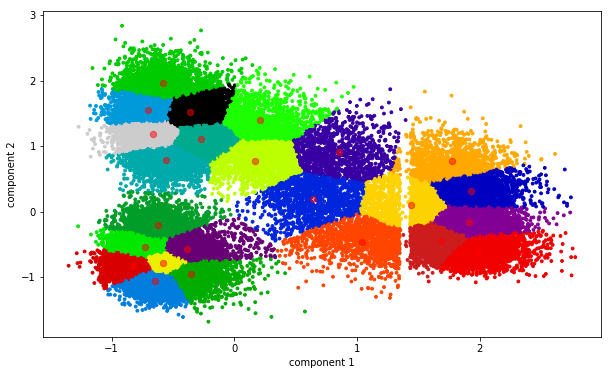

In [32]:
y_kmeans_fa , centers_fa = kmeans_pkg(data_fa, 24)
kmeans_plt (data_fa, y_kmeans_fa, centers_fa)

In [33]:
True_measures(data_fa, labeled_data_fa)

### True Cluster Membership

SSB : 102586.007567
Total_SSW : 25711.575265
Cluster-wise SSW:
Cluster 1: 381.100000
Cluster 2: 2337.090000
Cluster 3: 505.630000
Cluster 4: 142.840000
Cluster 5: 3542.310000
Cluster 6: 45.840000
Cluster 7: 182.530000
Cluster 8: 501.160000
Cluster 9: 2937.880000
Cluster 10: 300.750000
Cluster 11: 3499.720000
Cluster 12: 2086.600000
Cluster 13: 1038.050000
Cluster 14: 102.330000
Cluster 15: 116.370000
Cluster 16: 1730.830000
Cluster 17: 1476.550000
Cluster 18: 2327.050000
Cluster 19: 1517.770000
Cluster 20: 257.360000
Cluster 21: 114.360000
Cluster 22: 0.900000
Cluster 23: 120.450000
Cluster 24: 446.080000


In [34]:
new_measures(data_fa, 24)

### Class membership when K = 24

SSB : 104964.429635
Total_SSW : 13477.162103
Cluster-wise SSW:
Cluster 1: 356.030000
Cluster 2: 1228.770000
Cluster 3: 694.360000
Cluster 4: 373.150000
Cluster 5: 393.220000
Cluster 6: 566.150000
Cluster 7: 879.850000
Cluster 8: 391.410000
Cluster 9: 384.490000
Cluster 10: 594.080000
Cluster 11: 367.280000
Cluster 12: 351.170000
Cluster 13: 406.370000
Cluster 14: 257.010000
Cluster 15: 1251.960000
Cluster 16: 913.110000
Cluster 17: 359.100000
Cluster 18: 249.890000
Cluster 19: 604.420000
Cluster 20: 484.960000
Cluster 21: 1182.390000
Cluster 22: 289.560000
Cluster 23: 279.760000
Cluster 24: 618.670000

Iteration till convergence : 119


In [75]:
#table_fa = pd.crosstab(pd.Series(dim_13_labels, name = 'True Labels'), pd.Series(y_kmeans_fa, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (FA)')
#table_fa

In [74]:
#No_of_Misclassified_Cells_fa = table_fa.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (FA)')
#No_of_Misclassified_Cells_fa

In [73]:
#printmd('### Coverage Matrix for k=3 (FA)')
#coverage_matrix_fa = table_fa.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_fa

In [72]:
#print('total coverage for FA : %f' % (coverage_matrix_fa.values.sum()/(len(table_fa)*3)))

In [35]:
accuracy_fa = accuracycalculation (data_fa)
printmd('### Accuracy Matrix (FA-Kmeans)')
accuracy_fa

### Accuracy Matrix (FA-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,85.44
2,3,85.96
3,4,81.64
4,5,79.92
5,6,71.50
6,7,66.44
7,8,62.62
8,9,61.32
9,10,58.58


In [36]:
print("F1-Score for FA-Kmeans =", F1_measure(dim_13_labels, y_kmeans_fa))

F1-Score for FA-Kmeans = 0.282149304931


In [37]:
print("Adjusted Rand index for FA-Kmeans =", adjusted_rand_score(dim_13_labels, y_kmeans_fa))

Adjusted Rand index for FA-Kmeans = 0.226947735324


In [38]:
print("FMI for FA-Kmeans =", fowlkes_mallows_score(dim_13_labels, y_kmeans_fa)) 

FMI for FA-Kmeans = 0.296621721822


In [39]:
print("V-measure Score for FA-Kmeans =", v_measure_score(dim_13_labels, y_kmeans_fa))

V-measure Score for FA-Kmeans = 0.487614615191


# Independent Component Analysis (ICA)

--- 0.05981636047363281 seconds ---


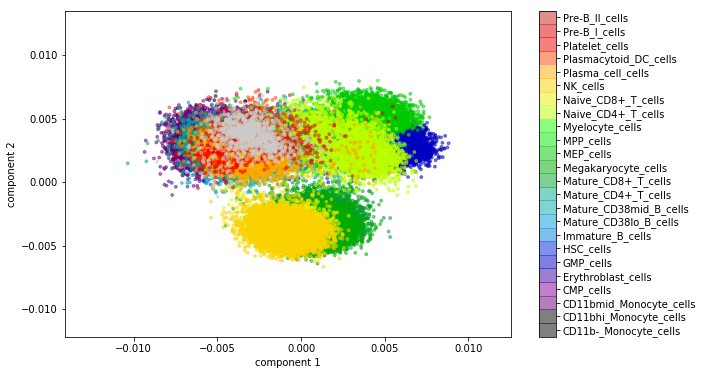

In [25]:
start_time_ica = time.time()
data_ica = ica(dim_13_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_ica))
Dim_Red_Plot (data_ica, dim_13_labels)

In [41]:
labeled_data_ica = addcluster(data_ica, dim_13_labels)

For n_clusters = 2 
 The average silhouette_score is : 0.5186719087928751


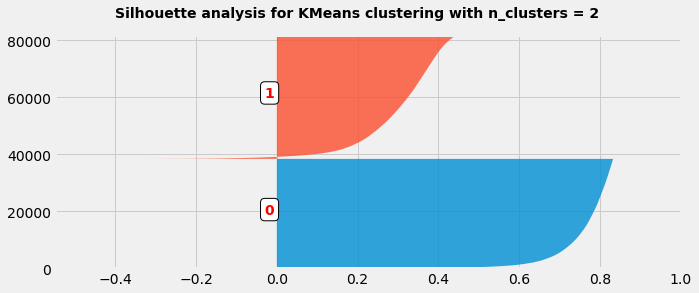

For n_clusters = 3 
 The average silhouette_score is : 0.7085582824479995


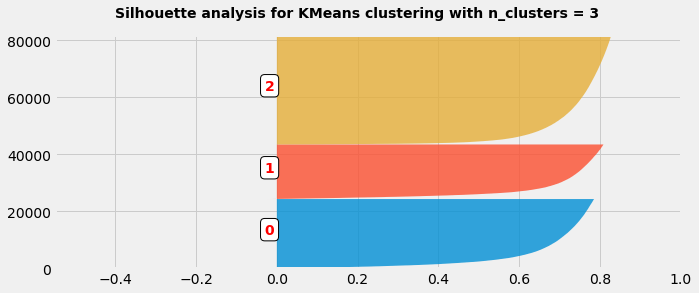

For n_clusters = 4 
 The average silhouette_score is : 0.5485526189424467


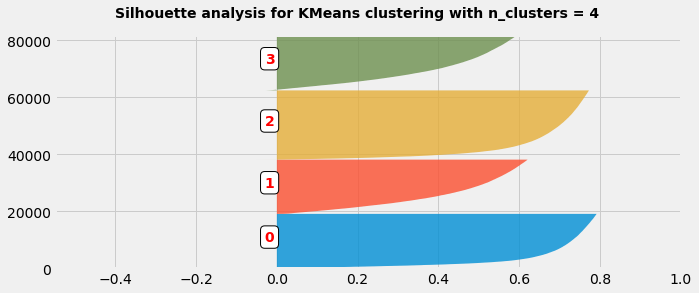

For n_clusters = 5 
 The average silhouette_score is : 0.4674388531234367


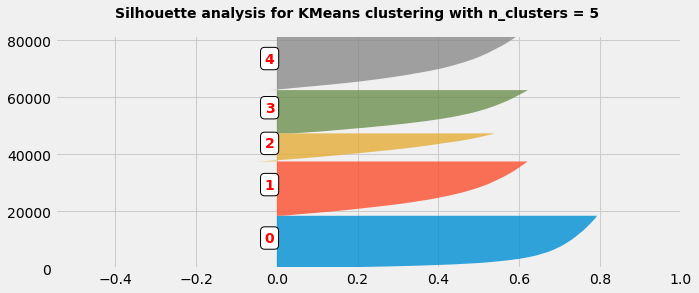

In [39]:
matrix_ica = pd.DataFrame(data_ica).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.4, 1]
silhouette_plot(matrix_ica, [2, 3, 4, 5], [-0.4, 1], len(data_ica))

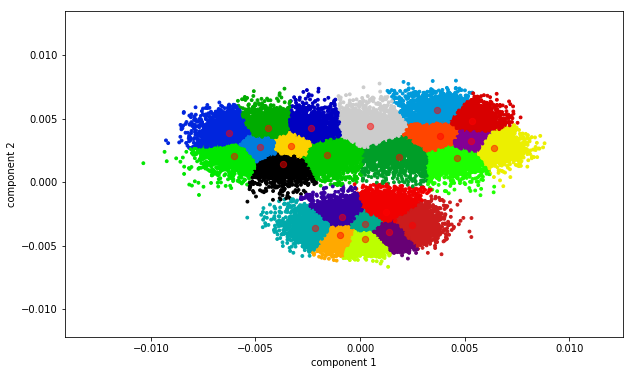

In [42]:
y_kmeans_ica , centers_ica = kmeans_pkg(data_ica, 24)
kmeans_plt (data_ica, y_kmeans_ica, centers_ica)

In [43]:
True_measures(data_ica, labeled_data_ica)

### True Cluster Membership

SSB : 374.350372
Total_SSW : 101.840388
Cluster-wise SSW:
Cluster 1: 1.230000
Cluster 2: 8.910000
Cluster 3: 1.720000
Cluster 4: 0.430000
Cluster 5: 13.710000
Cluster 6: 0.140000
Cluster 7: 0.550000
Cluster 8: 1.510000
Cluster 9: 11.440000
Cluster 10: 1.070000
Cluster 11: 15.450000
Cluster 12: 8.990000
Cluster 13: 4.270000
Cluster 14: 0.310000
Cluster 15: 0.370000
Cluster 16: 6.200000
Cluster 17: 6.750000
Cluster 18: 10.040000
Cluster 19: 5.610000
Cluster 20: 0.820000
Cluster 21: 0.450000
Cluster 22: 0.000000
Cluster 23: 0.380000
Cluster 24: 1.490000


In [44]:
new_measures(data_ica, 24)

### Class membership when K = 24

SSB : 383.232138
Total_SSW : 56.902554
Cluster-wise SSW:
Cluster 1: 0.000000
Cluster 2: 4.240000
Cluster 3: 3.630000
Cluster 4: 5.060000
Cluster 5: 2.050000
Cluster 6: 1.900000
Cluster 7: 0.000000
Cluster 8: 3.690000
Cluster 9: 3.470000
Cluster 10: 1.530000
Cluster 11: 2.770000
Cluster 12: 2.620000
Cluster 13: 1.940000
Cluster 14: 1.590000
Cluster 15: 2.220000
Cluster 16: 2.040000
Cluster 17: 1.260000
Cluster 18: 2.020000
Cluster 19: 2.500000
Cluster 20: 0.000000
Cluster 21: 4.300000
Cluster 22: 2.990000
Cluster 23: 2.580000
Cluster 24: 2.510000

Iteration till convergence : 99


In [71]:
#table_ica = pd.crosstab(pd.Series(dim_13_labels, name = 'True Labels'), pd.Series(y_kmeans_ica, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (ICA)')
#table_ica

In [70]:
#No_of_Misclassified_Cells_ica = table_ica.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (ICA)')
#No_of_Misclassified_Cells_ica

In [69]:
#printmd('### Coverage Matrix for k=3 (ICA)')
#coverage_matrix_ica = table_ica.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_ica

In [68]:
#print('total coverage for ICA : %f' % (coverage_matrix_ica.values.sum()/(len(table_ica)*3)))

In [45]:
accuracy_ica = accuracycalculation (data_ica)
printmd('### Accuracy Matrix (ICA-Kmeans)')
accuracy_ica

### Accuracy Matrix (ICA-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,99.81
2,3,91.34
3,4,88.41
4,5,77.04
5,6,72.71
6,7,69.18
7,8,65.39
8,9,60.06
9,10,60.65


In [46]:
print("F1-Score for ICA-Kmeans =", F1_measure(dim_13_labels, y_kmeans_ica))

F1-Score for ICA-Kmeans = 0.288056144053


In [47]:
print("Adjusted Rand index for ICA-Kmeans =", adjusted_rand_score(dim_13_labels, y_kmeans_ica))

Adjusted Rand index for ICA-Kmeans = 0.236954065607


In [48]:
print("FMI for ICA-Kmeans =", fowlkes_mallows_score(dim_13_labels, y_kmeans_ica)) 

FMI for ICA-Kmeans = 0.307690868291


In [49]:
print("V-measure Score for ICA-Kmeans =", v_measure_score(dim_13_labels, y_kmeans_ica))

V-measure Score for ICA-Kmeans = 0.494178721953


# Singular Value Decomposition (SVD)

--- 0.12073564529418945 seconds ---


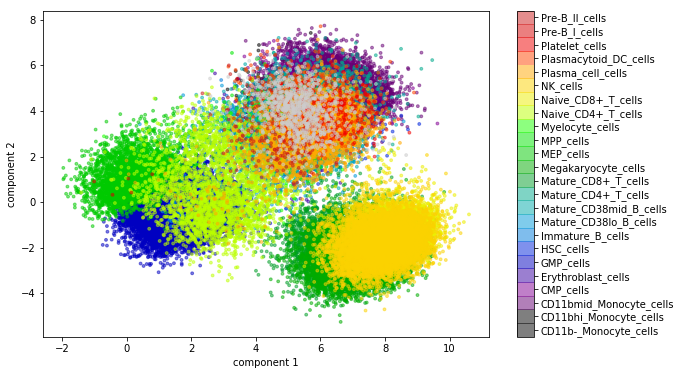

In [26]:
start_time_svd = time.time()
data_svd = svd(dim_13_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_svd))
Dim_Red_Plot (data_svd, dim_13_labels)

In [52]:
def svdplot(data, n_comp):
    printmd('### Analysis of SVD')
    # n_comp = [13, 11, 9, 7, 5, 3, 2]
    
    for i in range(len(n_comp)):
        svd = TruncatedSVD(n_components = n_comp[i])
        svd.fit(data)
        data_svd = svd.transform(data)
        svd_restored = svd.inverse_transform(data_svd)
        print('------------------------')
        print('pc shape: %d x %d' %data_svd.shape)
        print('%d principal components' % (n_comp[i]))
        print('Variance retained %.2f%%' % (sum(svd.explained_variance_ratio_) * 100))

        plt.figure(2, figsize=(5,2), dpi=100)
        xlab = ['SV %s' % j for j in list(range(0, n_comp[i]))]
        x = list(range(0, n_comp[i]))
        y = svd.explained_variance_ratio_
        ycum = y.cumsum()
        # grid(b=None, which='major', axis='both')
        plt.bar(x, y)
        plt.plot(x, ycum, c='red', marker='o', linewidth = 1)
        plt.axis(ymin=0, ymax=1)
        plt.xlabel('Principal Components')
        plt.ylabel('Explained Variance')
        plt.show()

### Analysis of SVD

------------------------
pc shape: 81747 x 12
12 principal components
Variance retained 98.96%


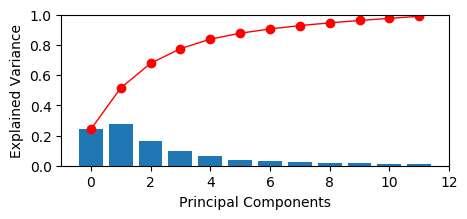

------------------------
pc shape: 81747 x 11
11 principal components
Variance retained 97.60%


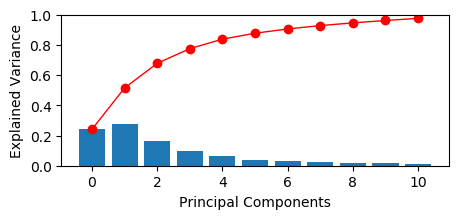

------------------------
pc shape: 81747 x 9
9 principal components
Variance retained 94.61%


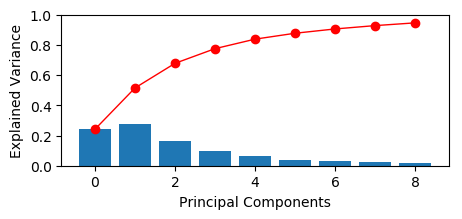

------------------------
pc shape: 81747 x 7
7 principal components
Variance retained 90.58%


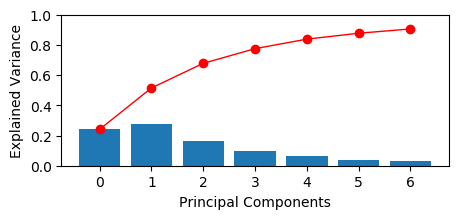

------------------------
pc shape: 81747 x 5
5 principal components
Variance retained 83.82%


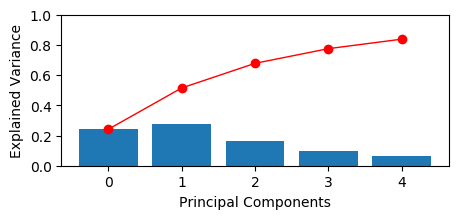

------------------------
pc shape: 81747 x 3
3 principal components
Variance retained 67.80%


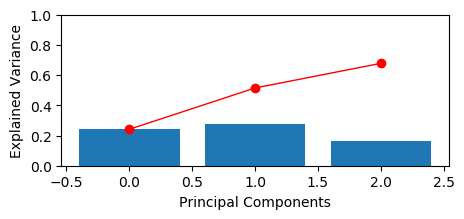

------------------------
pc shape: 81747 x 2
2 principal components
Variance retained 51.48%


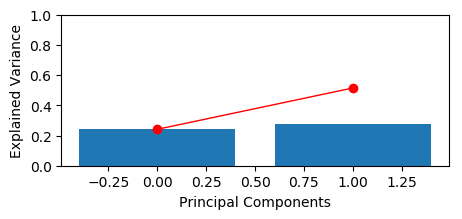

In [53]:
svdplot(dim_13_labeled_data, n_comp = [12, 11, 9, 7, 5, 3, 2])

In [54]:
labeled_data_svd = addcluster(data_svd, dim_13_labels)

For n_clusters = 2 
 The average silhouette_score is : 0.5636137860947463


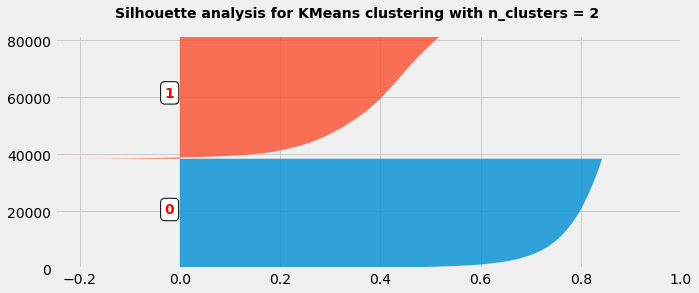

For n_clusters = 3 
 The average silhouette_score is : 0.7026083475661264


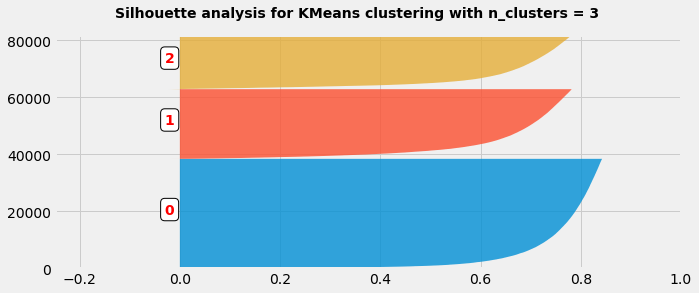

For n_clusters = 4 
 The average silhouette_score is : 0.5996275882133887


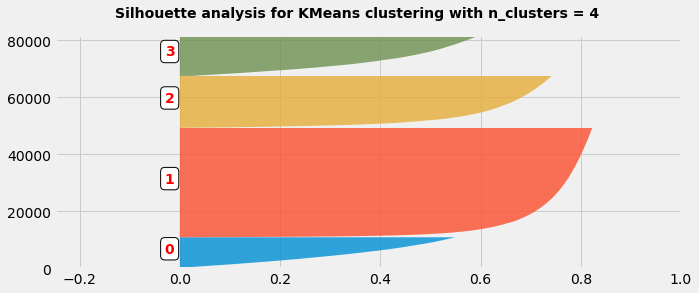

For n_clusters = 5 
 The average silhouette_score is : 0.43012799617538966


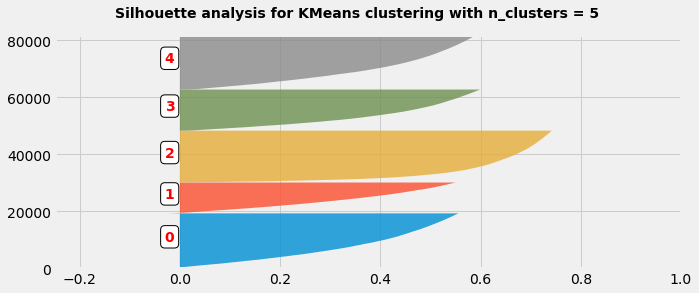

In [70]:
matrix_svd = pd.DataFrame(data_svd).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.25, 1]
silhouette_plot(matrix_svd, [2, 3, 4, 5], [-0.25, 1], len(data_svd))

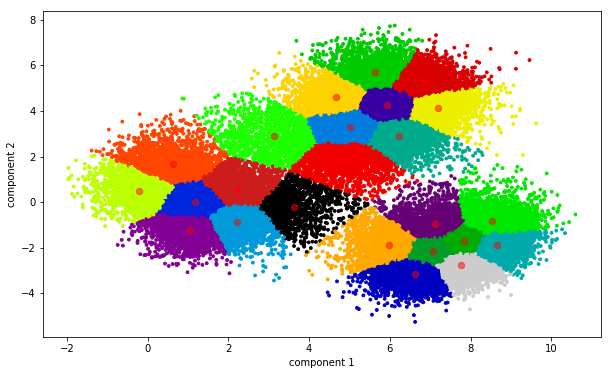

In [55]:
y_kmeans_svd , centers_svd = kmeans_pkg(data_svd, 24)
kmeans_plt (data_svd, y_kmeans_svd, centers_svd)

In [56]:
True_measures(data_svd, labeled_data_svd)

### True Cluster Membership

SSB : 284949.791142
Total_SSW : 80763.994904
Cluster-wise SSW:
Cluster 1: 930.160000
Cluster 2: 6782.450000
Cluster 3: 1272.450000
Cluster 4: 345.520000
Cluster 5: 11405.410000
Cluster 6: 91.530000
Cluster 7: 424.750000
Cluster 8: 985.320000
Cluster 9: 8851.100000
Cluster 10: 736.210000
Cluster 11: 12432.290000
Cluster 12: 7172.370000
Cluster 13: 3499.420000
Cluster 14: 248.720000
Cluster 15: 283.340000
Cluster 16: 4971.790000
Cluster 17: 5354.380000
Cluster 18: 8138.350000
Cluster 19: 4539.270000
Cluster 20: 599.190000
Cluster 21: 317.830000
Cluster 22: 3.210000
Cluster 23: 290.240000
Cluster 24: 1088.690000


In [59]:
new_measures(data_svd, 24)

### Class membership when K = 24

SSB : 291635.647259
Total_SSW : 46322.389197
Cluster-wise SSW:
Cluster 1: 2105.680000
Cluster 2: 2113.060000
Cluster 3: 3483.820000
Cluster 4: 0.000000
Cluster 5: 2294.300000
Cluster 6: 2319.420000
Cluster 7: 1666.700000
Cluster 8: 0.000000
Cluster 9: 4197.490000
Cluster 10: 1594.460000
Cluster 11: 2846.180000
Cluster 12: 1778.200000
Cluster 13: 1378.450000
Cluster 14: 2361.500000
Cluster 15: 1811.460000
Cluster 16: 3215.460000
Cluster 17: 0.000000
Cluster 18: 2700.260000
Cluster 19: 2640.110000
Cluster 20: 3197.130000
Cluster 21: 2508.410000
Cluster 22: 0.000000
Cluster 23: 2110.280000
Cluster 24: 0.000000

Iteration till convergence : 144


In [55]:
#table_svd = pd.crosstab(pd.Series(dim_13_labels, name = 'True Labels'), pd.Series(y_kmeans_svd, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (SVD)')
#table_svd

In [56]:
#No_of_Misclassified_Cells_svd = table_svd.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (SVD)')
#No_of_Misclassified_Cells_svd

In [57]:
#printmd('### Coverage Matrix for k=3 (SVD)')
#coverage_matrix_svd = table_svd.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_svd

In [58]:
#print('total coverage for SVD : %f' % (coverage_matrix_svd.values.sum()/(len(table_svd)*3)))

In [60]:
accuracy_svd = accuracycalculation (data_svd)
printmd('### Accuracy Matrix (SVD-Kmeans)')
accuracy_svd

### Accuracy Matrix (SVD-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,99.59
2,3,93.96
3,4,81.78
4,5,78.06
5,6,76.14
6,7,66.84
7,8,60.06
8,9,57.79
9,10,56.54


In [61]:
print("F1-Score for SVD-Kmeans =", F1_measure(dim_13_labels, y_kmeans_svd))

F1-Score for SVD-Kmeans = 0.268674067466


In [62]:
print("Adjusted Rand index for SVD-Kmeans =", adjusted_rand_score(dim_13_labels, y_kmeans_svd))

Adjusted Rand index for SVD-Kmeans = 0.215827451849


In [63]:
print("FMI for SVD-Kmeans =", fowlkes_mallows_score(dim_13_labels, y_kmeans_svd)) 

FMI for SVD-Kmeans = 0.28652295941


In [64]:
print("V-measure Score for SVD-Kmeans =", v_measure_score(dim_13_labels, y_kmeans_svd))

V-measure Score for SVD-Kmeans = 0.477325337973


# t-distributed Stochastic Neighbor Embedding (t-SNE)

In [28]:
data_tsne = np.array(pd.read_csv('Reduced_dim_data/dim_13_data_tsne.txt', sep = ",", header=-1))

--- 2060.983877182007 seconds ---


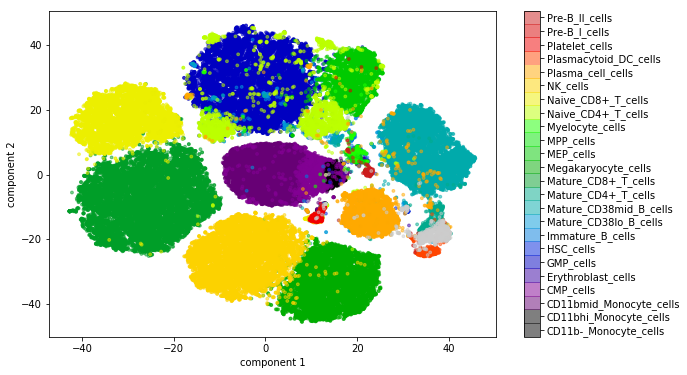

In [65]:
start_time_tsne = time.time()
# data_tsne = tsne(dim_13_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_tsne))
Dim_Red_Plot (data_tsne, dim_13_labels)

In [73]:
#np.savetxt("data_tsne.txt", data_tsne, delimiter=",")

In [77]:
labeled_data_tsne = addcluster(data_tsne, dim_13_labels)

In [ ]:
matrix_tsne = pd.DataFrame(data_tsne).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.25, 1]
silhouette_plot(matrix_tsne, [5, 6, 7, 8, 9, 10, 11, 12], [-0.25, 1], len(data_tsne))

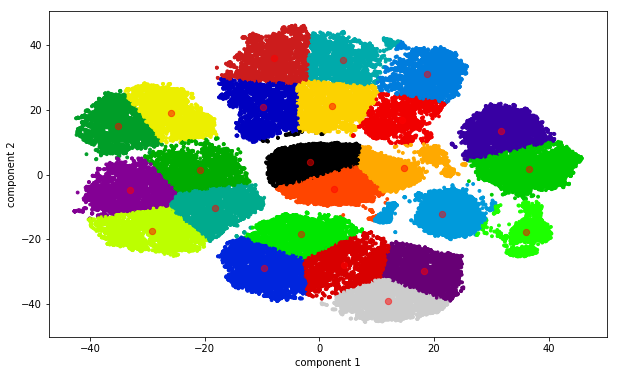

In [78]:
y_kmeans_tsne , centers_tsne = kmeans_pkg(data_tsne, 24)
kmeans_plt (data_tsne, y_kmeans_tsne, centers_tsne)

In [86]:
True_measures(data_tsne, labeled_data_tsne)

### True Cluster Membership

SSB : 2192599.684553
Total_SSW : 669755.397367
Cluster-wise SSW:
Cluster 1: 2356.420000
Cluster 2: 43386.620000
Cluster 3: 6314.000000
Cluster 4: 617.570000
Cluster 5: 118152.500000
Cluster 6: 689.780000
Cluster 7: 2154.560000
Cluster 8: 6819.920000
Cluster 9: 63666.490000
Cluster 10: 2213.260000
Cluster 11: 140823.540000
Cluster 12: 58164.870000
Cluster 13: 20329.270000
Cluster 14: 337.270000
Cluster 15: 1857.900000
Cluster 16: 43355.850000
Cluster 17: 51304.020000
Cluster 18: 77026.780000
Cluster 19: 24035.870000
Cluster 20: 971.260000
Cluster 21: 467.300000
Cluster 22: 21.560000
Cluster 23: 751.620000
Cluster 24: 3937.190000


In [87]:
new_measures(data_tsne, 24)

### Class membership when K = 24

SSB : 2256963.549899
Total_SSW : 484638.905002
Cluster-wise SSW:
Cluster 1: 15494.780000
Cluster 2: 0.000000
Cluster 3: 0.000000
Cluster 4: 9372.040000
Cluster 5: 20894.270000
Cluster 6: 57040.530000
Cluster 7: 29826.990000
Cluster 8: 18114.630000
Cluster 9: 19836.170000
Cluster 10: 19928.520000
Cluster 11: 32545.210000
Cluster 12: 23301.850000
Cluster 13: 28330.720000
Cluster 14: 21871.440000
Cluster 15: 27036.930000
Cluster 16: 29198.010000
Cluster 17: 0.000000
Cluster 18: 21295.100000
Cluster 19: 9788.680000
Cluster 20: 15242.260000
Cluster 21: 0.000000
Cluster 22: 39715.990000
Cluster 23: 19337.670000
Cluster 24: 26467.100000

Iteration till convergence : 44


In [59]:
#table_tsne = pd.crosstab(pd.Series(dim_13_labels, name = 'True Labels'), pd.Series(y_kmeans_tsne, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (tsne)')
#table_tsne

In [60]:
#No_of_Misclassified_Cells_tsne = table_tsne.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (tsne)')
#No_of_Misclassified_Cells_tsne

In [61]:
#printmd('### Coverage Matrix for k=3 (tsne)')
#coverage_matrix_tsne = table_tsne.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_tsne

In [62]:
#print('total coverage for tsne : %f' % (coverage_matrix_tsne.values.sum()/(len(table_tsne)*3)))

In [88]:
accuracy_tsne = accuracycalculation (data_tsne)
printmd('### Accuracy Matrix (t_SNE-Kmeans)')
accuracy_tsne

### Accuracy Matrix (t_SNE-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,94.51
2,3,90.47
3,4,91.13
4,5,89.32
5,6,87.12
6,7,86.21
7,8,84.82
8,9,86.87
9,10,86.14


In [89]:
print("F1-Score for t_SNE-Kmeans =", F1_measure(dim_13_labels, y_kmeans_tsne))

F1-Score for t_SNE-Kmeans = 0.506996525125


In [90]:
print("Adjusted Rand index for t_SNE-Kmeans =", adjusted_rand_score(dim_13_labels, y_kmeans_tsne))

Adjusted Rand index for t_SNE-Kmeans = 0.475317374799


In [91]:
print("FMI for t_SNE-Kmeans =", fowlkes_mallows_score(dim_13_labels, y_kmeans_tsne)) 

FMI for t_SNE-Kmeans = 0.557345816882


In [92]:
print("V-measure Score for t_SNE-Kmeans =", v_measure_score(dim_13_labels, y_kmeans_tsne))

V-measure Score for t_SNE-Kmeans = 0.759366896733


# Uniform Manifold Approximation and Projection (UMAP)

In [29]:
data_umap = np.array(pd.read_csv('Reduced_dim_data/dim_13_data_umap.txt', sep = ",", header=-1))

--- 361.2173066139221 seconds ---


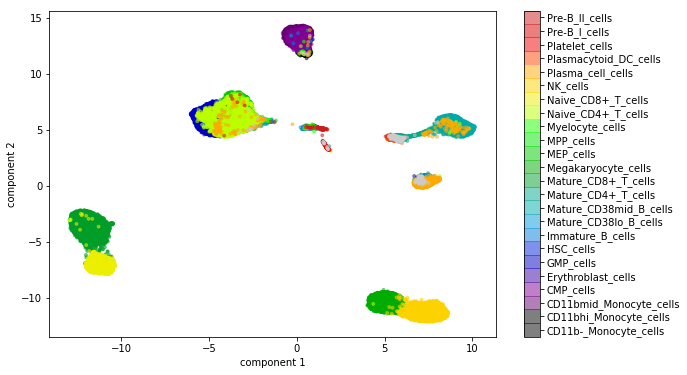

In [16]:
start_time_umap = time.time()
# data_umap = u_map(dim_13_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_umap))
Dim_Red_Plot (data_umap, dim_13_labels)

In [64]:
# np.savetxt("data_umap.txt", data_umap, delimiter=",")

In [66]:
labeled_data_umap = addcluster(data_umap, dim_13_labels)

In [ ]:
matrix_umap = pd.DataFrame(data_umap).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.4, 1]
silhouette_plot(matrix_umap, [2, 3, 4, 5], [-0.4, 1], len(data_umap))

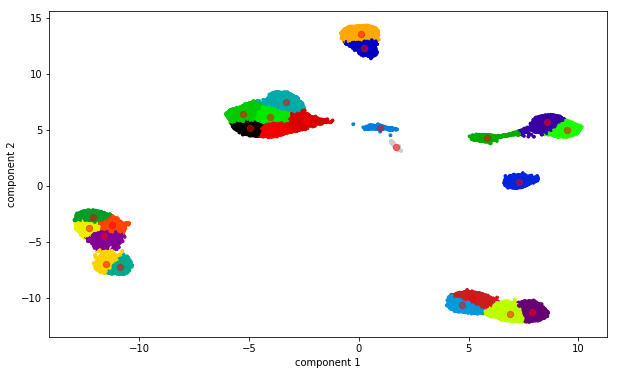

In [67]:
y_kmeans_umap , centers_umap = kmeans_pkg(data_umap, 24)
kmeans_plt (data_umap, y_kmeans_umap, centers_umap)

In [72]:
True_measures(data_umap, labeled_data_umap)

### True Cluster Membership

SSB : 863964.270306
Total_SSW : 64914.573530
Cluster-wise SSW:
Cluster 1: 517.210000
Cluster 2: 3813.360000
Cluster 3: 810.120000
Cluster 4: 115.880000
Cluster 5: 10340.270000
Cluster 6: 320.990000
Cluster 7: 452.690000
Cluster 8: 2664.080000
Cluster 9: 6680.820000
Cluster 10: 498.210000
Cluster 11: 11169.690000
Cluster 12: 4436.870000
Cluster 13: 1890.690000
Cluster 14: 48.360000
Cluster 15: 328.240000
Cluster 16: 3894.220000
Cluster 17: 4339.960000
Cluster 18: 6220.730000
Cluster 19: 5467.870000
Cluster 20: 86.090000
Cluster 21: 45.790000
Cluster 22: 2.150000
Cluster 23: 105.830000
Cluster 24: 664.440000


In [73]:
new_measures(data_umap, 24)

### Class membership when K = 24

SSB : 866154.724794
Total_SSW : 72976.212360
Cluster-wise SSW:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 0.000000
Cluster 4: 653.140000
Cluster 5: 6140.390000
Cluster 6: 0.000000
Cluster 7: 0.000000
Cluster 8: 1071.230000
Cluster 9: 1206.780000
Cluster 10: 0.000000
Cluster 11: 1533.040000
Cluster 12: 10913.360000
Cluster 13: 1274.320000
Cluster 14: 0.000000
Cluster 15: 1439.430000
Cluster 16: 6134.210000
Cluster 17: 0.000000
Cluster 18: 1415.170000
Cluster 19: 35377.670000
Cluster 20: 0.000000
Cluster 21: 4486.910000
Cluster 22: 0.000000
Cluster 23: 525.600000
Cluster 24: 804.970000

Iteration till convergence : 35


In [63]:
#table_umap = pd.crosstab(pd.Series(dim_13_labels, name = 'True Labels'), pd.Series(y_kmeans_umap, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (UMAP)')
#table_umap

In [64]:
#No_of_Misclassified_Cells_umap = table_umap.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (UMAP)')
#No_of_Misclassified_Cells_umap

In [65]:
#printmd('### Coverage Matrix for k=3 (UMAP)')
#coverage_matrix_umap = table_umap.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_umap

In [66]:
#print('total coverage for UMAP : %f' % (coverage_matrix_umap.values.sum()/(len(table_umap)*3)))

In [74]:
accuracy_umap = accuracycalculation (data_umap)
printmd('### Accuracy Matrix (UMAP-Kmeans)')
accuracy_umap

### Accuracy Matrix (UMAP-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,99.91
2,3,99.91
3,4,95.51
4,5,95.72
5,6,93.47
6,7,93.44
7,8,91.11
8,9,89.53
9,10,85.73


In [71]:
print("F1-Score for UMAP-Kmeans =", F1_measure(dim_13_labels, y_kmeans_umap))

F1-Score for UMAP-Kmeans = 0.5645058637272965


In [68]:
print("Adjusted Rand index for UMAP-Kmeans =", adjusted_rand_score(dim_13_labels, y_kmeans_umap))

Adjusted Rand index for UMAP-Kmeans = 0.5344276342572767


In [69]:
print("FMI for UMAP-Kmeans =", fowlkes_mallows_score(dim_13_labels, y_kmeans_umap)) 

FMI for UMAP-Kmeans = 0.6087887564756627


In [70]:
print("V-measure Score for UMAP-Kmeans =", v_measure_score(dim_13_labels, y_kmeans_umap))

V-measure Score for UMAP-Kmeans = 0.7890212787728151


# IsoMap

In [ ]:
start_time_isomap = time.time()
data_isomap = isomap(dim_13_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_isomap))
Dim_Red_Plot (data_isomap, dim_13_labels)

In [ ]:
labeled_data_isomap = addcluster(data_isomap, dim_13_labels)

In [ ]:
matrix_isomap = pd.DataFrame(data_isomap).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.25, 1]
silhouette_plot(matrix_tsne, [5, 6, 7, 8, 9, 10, 11, 12], [-0.25, 1], len(data_isomap))

In [ ]:
y_kmeans_isomap , centers_isomap = kmeans_pkg(data_isomap, 24)
kmeans_plt (data_isomap, y_kmeans_isomap, centers_isomap)

In [ ]:
True_measures(data_isomap, labeled_data_isomap)

In [ ]:
new_measures(data_isomap, 3)

In [ ]:
#table_isomap = pd.crosstab(pd.Series(dim_13_labels, name = 'True Labels'), pd.Series(y_kmeans_isomap, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (Isomap)')
#table_isomap

In [ ]:
#No_of_Misclassified_Cells_isomap = table_isomap.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (Isomap)')
#No_of_Misclassified_Cells_isomap

In [ ]:
#printmd('### Coverage Matrix for k=3 (Isomap)')
#coverage_matrix_isomap = table_isomap.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_isomap

In [ ]:
#print('total coverage for isomap : %f' % (coverage_matrix_Isomap.values.sum()/(len(table_isomap)*3)))

In [ ]:
accuracy_isomap = accuracycalculation (data_isomap)
printmd('### Accuracy Matrix (Isomap)')
accuracy_isomap

In [ ]:
print("F1-Score for Isomap-Kmeans =", F1_measure(dim_13_labels, y_kmeans_isomap))

In [ ]:
print("Adjusted Rand index for Isomap-Kmeans =", adjusted_rand_score(dim_13_labels, y_kmeans_isomap))

In [ ]:
print("FMI for Isomap-Kmeans =", fowlkes_mallows_score(dim_13_labels, y_kmeans_isomap)) 

In [ ]:
print("V-measure Score for Isomap-Kmeans =", v_measure_score(dim_13_labels, y_kmeans_isomap))

# MultiDimensional Scaling (MDS)

In [ ]:
data_mds = mds(dim_13_labeled_data, 2)
Dim_Red_Plot (data_mds, dim_13_labels)

In [ ]:
labeled_data_mds = addcluster(data_mds, dim_13_labels)

In [ ]:
matrix_mds = pd.DataFrame(data_mds).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.4, 1]
silhouette_plot(matrix_mds, [2, 3, 4, 5], [-0.4, 1], len(data_mds))

In [ ]:
y_kmeans_mds , centers_mds = kmeans_pkg(data_mds, 3)
kmeans_plt (data_mds, y_kmeans_mds, centers_mds)

In [ ]:
True_measures(data_mds, labeled_data_mds)

In [ ]:
new_measures(data_mds, 3)

In [ ]:
#table_mds = pd.crosstab(pd.Series(dim_13_labels, name = 'True Labels'), pd.Series(y_kmeans_mds, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (MDS)')
#table_mds

In [ ]:
#No_of_Misclassified_Cells_mds = table_mds.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (MDS)')
#No_of_Misclassified_Cells_mds

In [ ]:
#printmd('### Coverage Matrix for k=3 (MDS)')
#coverage_matrix_mds = table_mds.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_mds

In [ ]:
#print('total coverage for MDS : %f' % (coverage_matrix_mds.values.sum()/(len(table_mds)*3)))

In [ ]:
accuracy_mds = accuracycalculation (data_mds)
printmd('### Accuracy Matrix (MDS)')
accuracy_mds

In [ ]:
print("FMI for MDS-Kmeans =", fowlkes_mallows_score(y_kmeans_fa, dim_13_labels)) 

In [ ]:
print("V-measure Score for MDS-Kmeans =", v_measure_score(y_kmeans_pca, dim_13_labels))

# Mixture Models

# PCA-Mixture_model

In [26]:
y_gmm_pca = Mixture_model(data_pca, 24)

In [27]:
print("F1-Score for PCA-Mixture_model =", F1_measure(dim_13_labels, y_gmm_pca))

F1-Score for PCA-Mixture_model = 0.30451193745780253


In [28]:
print("Adjusted Rand index for PCA-Mixture_model =", adjusted_rand_score(dim_13_labels, y_gmm_pca))

Adjusted Rand index for PCA-Mixture_model = 0.2535299381944824


In [29]:
print("FMI for PCA-Mixture_model =", fowlkes_mallows_score(dim_13_labels, y_gmm_pca)) 

FMI for PCA-Mixture_model = 0.323635982277027


In [30]:
print("V-measure Score for PCA-Mixture_model =", v_measure_score(dim_13_labels, y_gmm_pca))

V-measure Score for PCA-Mixture_model = 0.49421845046834384


In [33]:
accuracy_pca_gmm = accuracycalculation_gmm (data_pca)
printmd('### Accuracy Matrix (PCA and Mixture Model)')
accuracy_pca_gmm

### Accuracy Matrix (PCA and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,99.92
2,3,93.85
3,4,85.16
4,5,82.39
5,6,78.44
6,7,69.93
7,8,68.01
8,9,61.89
9,10,56.02


# FA-Mixture_model

In [34]:
y_gmm_fa = Mixture_model(data_fa, 24)

In [35]:
print("F1-Score for FA-Mixture_model =", F1_measure(dim_13_labels, y_gmm_fa))

F1-Score for FA-Mixture_model = 0.30368810593015383


In [36]:
print("Adjusted Rand index for FA-Mixture_model =", adjusted_rand_score(dim_13_labels, y_gmm_fa))

Adjusted Rand index for FA-Mixture_model = 0.24347631808380082


In [37]:
print("FMI for FA-Mixture_model =", fowlkes_mallows_score(dim_13_labels, y_gmm_fa)) 

FMI for FA-Mixture_model = 0.3120019456023895


In [38]:
print("V-measure Score for FA-Mixture_model =", v_measure_score(dim_13_labels, y_gmm_fa))

V-measure Score for FA-Mixture_model = 0.48922600225519686


In [39]:
accuracy_fa_gmm = accuracycalculation_gmm (data_fa)
printmd('### Accuracy Matrix (FA and Mixture Model)')
accuracy_fa_gmm

### Accuracy Matrix (FA and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,88.69
2,3,86.03
3,4,85.37
4,5,81.14
5,6,80.38
6,7,77.47
7,8,66.02
8,9,62.56
9,10,59.93


# ICA-Mixture_model

In [40]:
y_gmm_ica = Mixture_model(data_ica, 24)

In [41]:
print("F1-Score for ICA-Mixture_model =", F1_measure(dim_13_labels, y_gmm_ica))

F1-Score for ICA-Mixture_model = 0.5050123789470741


In [42]:
print("Adjusted Rand index for ICA-Mixture_model =", adjusted_rand_score(dim_13_labels, y_gmm_ica))

Adjusted Rand index for ICA-Mixture_model = 0.43029758159733644


In [43]:
print("FMI for ICA-Mixture_model =", fowlkes_mallows_score(dim_13_labels, y_gmm_ica)) 

FMI for ICA-Mixture_model = 0.5244807136354692


In [44]:
print("V-measure Score for ICA-Mixture_model =", v_measure_score(dim_13_labels, y_gmm_ica))

V-measure Score for ICA-Mixture_model = 0.5607185521642474


In [45]:
accuracy_ica_gmm = accuracycalculation_gmm (data_ica)
printmd('### Accuracy Matrix (ICA and Mixture Model)')
accuracy_ica_gmm

### Accuracy Matrix (ICA and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,92.99
2,3,93.07
3,4,85.92
4,5,82.54
5,6,76.53
6,7,78.63
7,8,79.99
8,9,84.47
9,10,60.44


# SVD-Mixture_model

In [46]:
y_gmm_svd = Mixture_model(data_svd, 24)

In [47]:
print("F1-Score for SVD-Mixture_model =", F1_measure(dim_13_labels, y_gmm_svd))

F1-Score for SVD-Mixture_model = 0.284656075596218


In [48]:
print("Adjusted Rand index for SVD-Mixture_model =", adjusted_rand_score(dim_13_labels, y_gmm_svd))

Adjusted Rand index for SVD-Mixture_model = 0.22933163873331547


In [49]:
print("FMI for SVD-Mixture_model =", fowlkes_mallows_score(dim_13_labels, y_gmm_svd)) 

FMI for SVD-Mixture_model = 0.2988841985434476


In [50]:
print("V-measure Score for SVD-Mixture_model =", v_measure_score(dim_13_labels, y_gmm_svd))

V-measure Score for SVD-Mixture_model = 0.4805805237919061


In [51]:
accuracy_svd_gmm = accuracycalculation_gmm (data_svd)
printmd('### Accuracy Matrix (SVD and Mixture Model)')
accuracy_svd_gmm

### Accuracy Matrix (SVD and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,99.91
2,3,95.19
3,4,82.13
4,5,80.75
5,6,77.04
6,7,75.26
7,8,60.49
8,9,61.16
9,10,57.50


# t_SNE-Mixture_model

In [52]:
y_gmm_tsne = Mixture_model(data_tsne, 24)

In [53]:
print("F1-Score for t_SNE-Mixture_model =", F1_measure(dim_13_labels, y_gmm_tsne))

F1-Score for t_SNE-Mixture_model = 0.5018360829634688


In [54]:
print("Adjusted Rand index for t_SNE-Mixture_model =", adjusted_rand_score(dim_13_labels, y_gmm_tsne))

Adjusted Rand index for t_SNE-Mixture_model = 0.4695768277560245


In [55]:
print("FMI for t_SNE-Mixture_model =", fowlkes_mallows_score(dim_13_labels, y_gmm_tsne)) 

FMI for t_SNE-Mixture_model = 0.5505023011665978


In [56]:
print("V-measure Score for t_SNE-Mixture_model =", v_measure_score(dim_13_labels, y_gmm_tsne))

V-measure Score for t_SNE-Mixture_model = 0.7582174887798238


In [57]:
accuracy_tsne_gmm = accuracycalculation_gmm (data_tsne)
printmd('### Accuracy Matrix (t_SNE and Mixture Model)')
accuracy_tsne_gmm

### Accuracy Matrix (t_SNE and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,96.77
2,3,92.62
3,4,89.99
4,5,93.69
5,6,92.82
6,7,87.58
7,8,84.45
8,9,87.69
9,10,85.43


# UMAP-Mixture_model

In [58]:
y_gmm_umap = Mixture_model(data_umap, 24)

In [59]:
print("F1-Score for UMAP-Mixture_model =", F1_measure(dim_13_labels, y_gmm_umap))

F1-Score for UMAP-Mixture_model = 0.5880311991487766


In [60]:
print("Adjusted Rand index for UMAP-Mixture_model =", adjusted_rand_score(dim_13_labels, y_gmm_umap))

Adjusted Rand index for UMAP-Mixture_model = 0.5577847232142724


In [61]:
print("FMI for UMAP-Mixture_model =", fowlkes_mallows_score(dim_13_labels, y_gmm_umap)) 

FMI for UMAP-Mixture_model = 0.6247294470071686


In [62]:
print("V-measure Score for UMAP-Mixture_model =", v_measure_score(dim_13_labels, y_gmm_umap))

V-measure Score for UMAP-Mixture_model = 0.7937848923106108


In [63]:
accuracy_umap_gmm = accuracycalculation_gmm (data_umap)
printmd('### Accuracy Matrix (umap and Mixture Model)')
accuracy_umap_gmm

### Accuracy Matrix (umap and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,99.91
2,3,99.91
3,4,93.32
4,5,95.72
5,6,95.71
6,7,92.96
7,8,88.19
8,9,91.27
9,10,88.35


# Isomap-Mixture_model

In [ ]:
y_gmm_isomap = Mixture_model(data_isomap, 24)

In [ ]:
print("F1-Score for Isomap-Mixture_model =", F1_measure(dim_13_labels, y_gmm_isomap))

In [ ]:
print("Adjusted Rand index for Isomap-Mixture_model =", adjusted_rand_score(dim_13_labels, y_gmm_isomap))

In [ ]:
print("FMI for Isomap-Mixture_model =", fowlkes_mallows_score(dim_13_labels, y_gmm_isomap)) 

In [ ]:
print("V-measure Score for Isomap-Mixture_model =", v_measure_score(dim_13_labels, y_gmm_isomap))

In [ ]:
accuracy_umap_gmm = accuracycalculation_gmm (data_isomap)
printmd('### Accuracy Matrix (Isomap and Mixture Model)')
accuracy_umap_gmm

# 3-D Plotting

In [75]:
def Dim_Red_Plot_3d (data, labels):
    '''
    data = data_new
    labels =  dim_13_labels
    
    '''
    fig = pyplot.figure(figsize=(15,10))
    ax = Axes3D(fig)
    X = np.arange(-42, 42, 2)
    Y = np.arange(-42, 42, 2)
    X, Y = np.meshgrid(X, Y)

    ax.scatter(np.array(data)[:, 0], np.array(data)[:, 1], labels, c=labels, edgecolor='none', alpha=0.5,
               cmap=plt.cm.get_cmap('gist_ncar', 24))

    cmap = mpl.cm.gist_ncar
    #for i in range (1, 25):
    #    ax.plot_surface(X, Y, (X*0 + Y*0)+i , color=cmap(i / float(24)))

    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.set_zlabel('Label')
    pyplot.show()

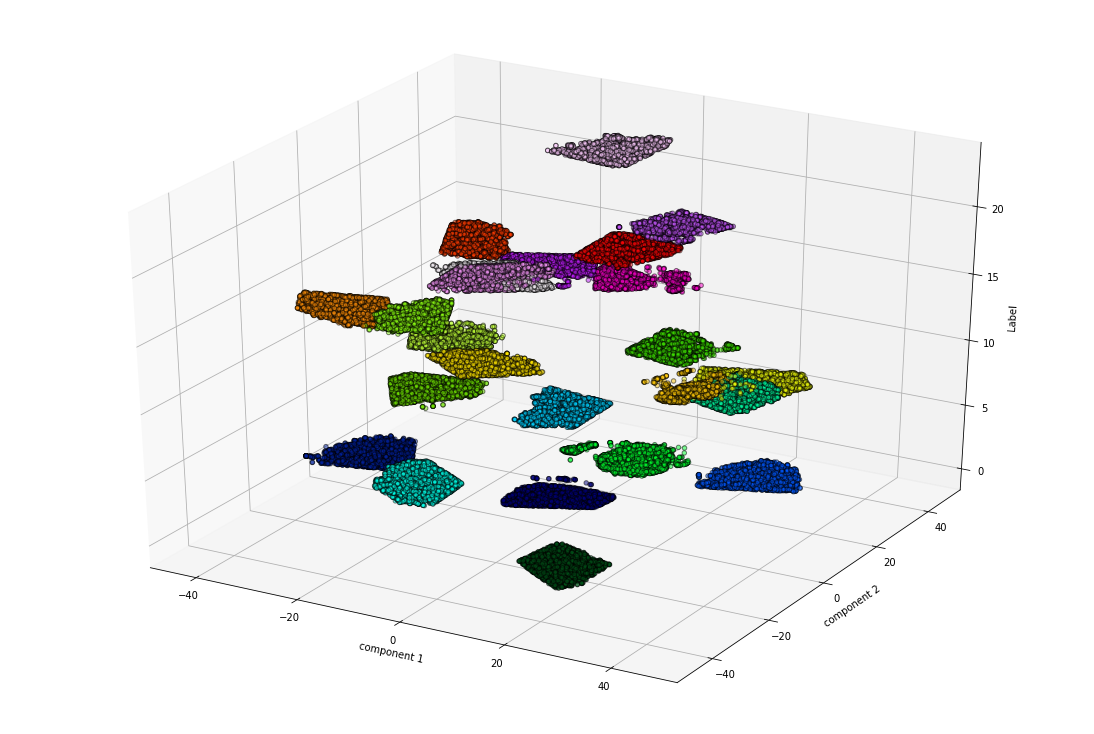

In [79]:
# Dim_Red_Plot_3d (data_tsne, dim_13_labels)
Dim_Red_Plot_3d (data_tsne, y_kmeans_tsne)

# Results on validation data

## PCA+K-means

In [18]:
val_pca = pca(validation_samples, 2)

In [19]:
y_kmeans_val_pca , centers_val_pca = kmeans_pkg(val_pca, 24)

In [20]:
print("F1-Score for PCA-Kmeans =", F1_measure(validation_labels, y_kmeans_val_pca))

F1-Score for PCA-Kmeans = 0.28697475441939074


## FA+K-means

In [21]:
fa, val_fa = fa(validation_samples, 2)

In [22]:
np.savetxt("val_fa_13dim.txt", val_fa, delimiter=",")

In [23]:
y_kmeans_val_fa , centers_val_fa = kmeans_pkg(val_fa, 24)

In [24]:
print("F1-Score for FA-Kmeans =", F1_measure(validation_labels, y_kmeans_val_fa))

F1-Score for FA-Kmeans = 0.28166268160107244


## ICA+K-means

In [25]:
val_ica = ica(validation_samples, 2)

In [26]:
y_kmeans_val_ica , centers_val_ica = kmeans_pkg(val_ica, 24)

In [27]:
print("F1-Score for ICA-Kmeans =", F1_measure(validation_labels, y_kmeans_val_ica))

F1-Score for ICA-Kmeans = 0.28720459852028446


## SVD+K-means

In [28]:
val_svd = svd(validation_samples, 2)

In [29]:
y_kmeans_val_svd , centers_val_svd = kmeans_pkg(val_svd, 24)

In [30]:
print("F1-Score for SVD-Kmeans =", F1_measure(validation_labels, y_kmeans_val_svd))

F1-Score for SVD-Kmeans = 0.2692362160060685


## t-SNE+K-means

In [31]:
val_tsne = tsne(validation_samples, 2)

In [32]:
np.savetxt("val_tsne_13dim.txt", val_tsne, delimiter=",")

In [33]:
y_kmeans_val_tsne , centers_val_tsne = kmeans_pkg(val_tsne, 24)

In [34]:
print("F1-Score for t-SNE-Kmeans =", F1_measure(validation_labels, y_kmeans_val_tsne))

F1-Score for t-SNE-Kmeans = 0.5106060362889424


## UMAP+K-means

In [35]:
val_umap = u_map(validation_samples, 2)

In [36]:
np.savetxt("val_umap_13dim.txt", val_umap, delimiter=",")

In [37]:
y_kmeans_val_umap , centers_val_umap = kmeans_pkg(val_umap, 24)

In [38]:
print("F1-Score for UMAP-Kmeans =", F1_measure(validation_labels, y_kmeans_val_umap))

F1-Score for UMAP-Kmeans = 0.5795167943146715


## HDBSCAN

## PCA-HDBSCAN

In [31]:
y_HDBSCAN_pca = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_pca)

In [33]:
print("F1-Score for PCA-HDBSCAN =", F1_measure(dim_13_labels, y_HDBSCAN_pca))

F1-Score for PCA-HDBSCAN = 0.44167141066802185


In [34]:
print("Adjusted Rand index for PCA-HDBSCAN =", adjusted_rand_score(dim_13_labels, y_HDBSCAN_pca))

Adjusted Rand index for PCA-HDBSCAN = 0.33583479485879525


In [35]:
print("FMI for PCA-HDBSCAN =", fowlkes_mallows_score(dim_13_labels, y_HDBSCAN_pca)) 

FMI for PCA-HDBSCAN = 0.5259870400949673


In [36]:
print("V-measure Score for PCA-HDBSCAN =", v_measure_score(dim_13_labels, y_HDBSCAN_pca))

V-measure Score for PCA-HDBSCAN = 0.5566964054947363


## FA-HDBSCAN

In [37]:
y_HDBSCAN_fa = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_fa)

In [38]:
print("F1-Score for FA-HDBSCAN =", F1_measure(dim_13_labels, y_HDBSCAN_fa))

F1-Score for FA-HDBSCAN = 0.45143042938180566


In [39]:
print("Adjusted Rand index for FA-HDBSCAN =", adjusted_rand_score(dim_13_labels, y_HDBSCAN_fa))

Adjusted Rand index for FA-HDBSCAN = 0.3488727105892419


In [40]:
print("FMI for FA-HDBSCAN =", fowlkes_mallows_score(dim_13_labels, y_HDBSCAN_fa)) 

FMI for FA-HDBSCAN = 0.5304782172144434


In [41]:
print("V-measure Score for FA-HDBSCAN =", v_measure_score(dim_13_labels, y_HDBSCAN_fa))

V-measure Score for FA-HDBSCAN = 0.5696816988884136


## ICA-HDBSCAN

In [42]:
y_HDBSCAN_ica = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_ica)

In [43]:
print("F1-Score for ICA-HDBSCAN =", F1_measure(dim_13_labels, y_HDBSCAN_ica))

F1-Score for ICA-HDBSCAN = 0.44240979836546074


In [44]:
print("Adjusted Rand index for ICA-HDBSCAN =", adjusted_rand_score(dim_13_labels, y_HDBSCAN_ica))

Adjusted Rand index for ICA-HDBSCAN = 0.337371550107827


In [45]:
print("FMI for ICA-HDBSCAN =", fowlkes_mallows_score(dim_13_labels, y_HDBSCAN_ica)) 

FMI for ICA-HDBSCAN = 0.5236386836023081


In [46]:
print("V-measure Score for ICA-HDBSCAN =", v_measure_score(dim_13_labels, y_HDBSCAN_ica))

V-measure Score for ICA-HDBSCAN = 0.5516758210557303


## SVD-HDBSCAN

In [47]:
y_HDBSCAN_svd = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_svd)

In [48]:
print("F1-Score for SVD-HDBSCAN =", F1_measure(dim_13_labels, y_HDBSCAN_svd))

F1-Score for SVD-HDBSCAN = 0.4387510204917921


In [49]:
print("Adjusted Rand index for SVD-HDBSCAN =", adjusted_rand_score(dim_13_labels, y_HDBSCAN_svd))

Adjusted Rand index for SVD-HDBSCAN = 0.33214359619620815


In [50]:
print("FMI for SVD-HDBSCAN =", fowlkes_mallows_score(dim_13_labels, y_HDBSCAN_svd)) 

FMI for SVD-HDBSCAN = 0.5235804851865091


In [51]:
print("V-measure Score for SVD-HDBSCAN =", v_measure_score(dim_13_labels, y_HDBSCAN_svd))

V-measure Score for SVD-HDBSCAN = 0.5552972578608613


## t_SNE-HDBSCAN

In [109]:
y_HDBSCAN_tsne = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_tsne)

In [110]:
print("F1-Score for tsne-HDBSCAN =", F1_measure(dim_13_labels, y_HDBSCAN_tsne))

F1-Score for tsne-HDBSCAN = 0.7707276421622246


In [111]:
print("Adjusted Rand index for tsne-HDBSCAN =", adjusted_rand_score(dim_13_labels, y_HDBSCAN_tsne))

Adjusted Rand index for tsne-HDBSCAN = 0.737811514851289


In [112]:
print("FMI for tsne-HDBSCAN =", fowlkes_mallows_score(dim_13_labels, y_HDBSCAN_tsne)) 

FMI for tsne-HDBSCAN = 0.7893026892972532


In [113]:
print("V-measure Score for tsne-HDBSCAN =", v_measure_score(dim_13_labels, y_HDBSCAN_tsne))

V-measure Score for tsne-HDBSCAN = 0.8503611359350022


## UMAP-HDBSCAN

In [76]:
y_HDBSCAN_umap = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=200,
).fit_predict(data_umap)

In [77]:
print("F1-Score for umap-HDBSCAN =", F1_measure(dim_13_labels, y_HDBSCAN_umap))

F1-Score for umap-HDBSCAN = 0.9243133472123288


In [78]:
print("Adjusted Rand index for umap-HDBSCAN =", adjusted_rand_score(dim_13_labels, y_HDBSCAN_umap))

Adjusted Rand index for umap-HDBSCAN = 0.9151578605340275


In [79]:
print("FMI for umap-HDBSCAN =", fowlkes_mallows_score(dim_13_labels, y_HDBSCAN_umap)) 

FMI for umap-HDBSCAN = 0.9252480087158833


In [80]:
print("V-measure Score for umap-HDBSCAN =", v_measure_score(dim_13_labels, y_HDBSCAN_umap))

V-measure Score for umap-HDBSCAN = 0.9047311376113661
